In [1]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import pandas as pd
from kappa_loss_perceptron import KappaLossPerceptron

- move to colab for gpu support?

In [2]:
df = pd.read_csv("./data/preprocessed_data.csv", index_col=0)

TARGET = "NSP"
FEATURES = df.columns.drop(TARGET)

# Reserve a "final final" test set
Xdf = df[FEATURES]
ydf = df[TARGET]
NUM_CLASSES = 3

In [3]:
X = Xdf.values
y = ydf.values

# Penalties for different types of class confusion
weights = np.array([
# Predicted   N    S    P     # True
            [0.0, 0.5, 0.6],  # N
            [1.0, 0.0, 0.3],  # S
            [2.0, 0.6, 0.0]   # P
])
klp = KappaLossPerceptron(num_classes=NUM_CLASSES, weight_matrix=weights)

In [7]:
klp.fit(X, y, epochs=20, clean=False)
y_hat = klp.predict(X)

2021-12-08 15:56:32.509510: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
Compiling module jit_loss__1.104432
********************************


<AxesSubplot:>

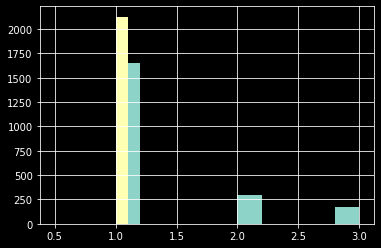

In [6]:
pd.Series(y).hist() 
pd.Series(y_hat).hist() 